In [1]:
!pip install sentinelhub
!pip install tqdm
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.1 MB/s eta 0:00:00


#  Download full SAFE archive as .zip for acolite processing

In [2]:
import os
import sys
import pandas as pd
import requests
import json
import datetime
from tqdm import tqdm
from sentinelhub import (SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)
import netCDF4 as nc
from netCDF4 import Dataset

In [15]:
ds['pixel_x'][0]

masked_array(data=[2170, 2171, 2171, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-999,
            dtype=int16)

In [99]:
import pandas as pd
from netCDF4 import Dataset
from datetime import datetime
import numpy as np
from shapely.geometry import Point, box

# ----------------------------------------
# 1. Define AOI
# ----------------------------------------
from shapely.geometry import box

aoi_list = [
    {
        'name': 'Po River Plume',
        'bbox': box(12.45, 44.825, 12.7, 45.055),  # [min_lon, min_lat, max_lon, max_lat]
    },
    {
        'name' : 'North East Corsica', # 'T32TNN'
        'bbox' : box(9.6, 42.95, 9.9, 43.155)
    },
    {
        'name': 'South East Calabria', # 'T33SXC'
        'bbox': box(16.5, 38.35, 16.755, 38.555)
    }
]


# ----------------------------------------
# 2. Load Excel file
# ----------------------------------------
excel_path = "/content/LM_centroids.xlsx"
df_excel = pd.read_excel(excel_path, engine='openpyxl')
df_excel['Formatted_time'] = pd.to_datetime(df_excel['Str_time'], format='%Y%m%dT%H%M%S')

# ----------------------------------------
# 3. Load NetCDF file
# ----------------------------------------
ds = Dataset('/content/drive/MyDrive/WASP_LW_SENT2_MED_L1C_B_201506_202109_10m_6y_NRT_v1.0.nc')

nc_times = ds.variables['s2_product'][:]  # e.g., b'S2A_MSIL1C_20180612T081021_...'
nc_lat = ds.variables['lat_centroid'][:]
nc_lon = ds.variables['lon_centroid'][:]
n_pixels_fil = ds.variables['n_pixels_fil'][:]
pixel_x = ds.variables['pixel_x'][:]          # shape: (N_filaments, 2563)
pixel_y = ds.variables['pixel_y'][:]
pixel_spec = ds.variables['pixel_spec'][:]    # shape: (N_filaments, 2563, 13)
limits = ds.variables['limits'][:]
x_centroid = ds.variables['x_centroid'][:]
y_centroid = ds.variables['y_centroid'][:]

# ----------------------------------------
# 4. Parse NetCDF times
# ----------------------------------------
def extract_datetime_from_product(product_str):
    str_time = product_str.data.tobytes().decode('utf-8').split('_')[2]
    return datetime.strptime(str_time, '%Y%m%dT%H%M%S')

nc_datetimes = [extract_datetime_from_product(p) for p in nc_times]

# ----------------------------------------
# 5. get tiles that covers the AOIs
# ----------------------------------------
from shapely.geometry import Point
from collections import defaultdict

# Initialize mapping: AOI name → set of tile names
aoi_tiles = defaultdict(set)

for i in range(len(nc_lat)):
    point = Point(nc_lon[i], nc_lat[i])
    product = nc_times[i].data.tobytes().decode('utf-8')
    tile = product.split('_')[5]  # Extract tile from product name

    for aoi in aoi_list:
        if aoi['bbox'].contains(point):
            aoi_tiles[aoi['name']].add(tile)
            break  # skip to next filament

# Print results
for aoi_name, tiles in aoi_tiles.items():
    print(f"🗺️ AOI '{aoi_name}' intersects {len(tiles)} tile(s): {sorted(tiles)}")


# ----------------------------------------
# 6. Match Excel to NetCDF annotations
# ----------------------------------------
matched_rows = []
index = 0

for _, row in df_excel.iterrows():
    excel_time = datetime.strptime(row['Str_time'], '%Y%m%dT%H%M%S')
    excel_lat = row['Latitude']
    excel_lon = row['Longitude']

    # Compute time & spatial difference
    time_diffs = [abs((excel_time - nc_time).days) for nc_time in nc_datetimes]
    spatial_dists = np.sqrt((excel_lat - nc_lat)**2 + (excel_lon - nc_lon)**2)

    # Valid candidates within ±1 day and 0.025° (≈2.5 km) - requires in case of loss of decimal precision
    valid_indices = [i for i in range(len(nc_datetimes))
                     if time_diffs[i] <= 1 and spatial_dists[i] <= 0.02]

    if valid_indices:
        best_idx = valid_indices[np.argmin([spatial_dists[i] for i in valid_indices])]
        n = n_pixels_fil[best_idx]

        matched_point = Point(nc_lon[best_idx], nc_lat[best_idx])
        aoi_label = None

        tile = nc_times[best_idx].data.tobytes().decode('utf-8').split('_')[5]

        for aoi_name, tiles in aoi_tiles.items():
            if tile in tiles:
                aoi_label = aoi_name
                break


        matched_rows.append({
            'index': index,
            'excel_datetime': excel_time,
            'excel_lat': excel_lat,
            'excel_lon': excel_lon,
            'excel_year': excel_time.year,
            'excel_month': excel_time.month,
            'matched_time': nc_datetimes[best_idx],
            'matched_lat': nc_lat[best_idx],
            'matched_lon': nc_lon[best_idx],
            'matched_s2_product': nc_times[best_idx].data.tobytes().decode('utf-8'),
            'match_distance_deg': spatial_dists[best_idx],
            'AOI': aoi_label,
            'tile_name': nc_times[best_idx].data.tobytes().decode('utf-8').split('_')[5],
            'pixel_x': pixel_x[best_idx].compressed(),
            'pixel_y': pixel_y[best_idx].compressed(),
            'limits': limits[best_idx].data,
            'cx': x_centroid[best_idx],
            'cy': y_centroid[best_idx],
            'pixel_spec':pixel_spec[best_idx].compressed().reshape(-1, 13)

        })

    index += 1

# ----------------------------------------
# 6. Save to CSV (or optionally Pickle)
# ----------------------------------------
df_matched = pd.DataFrame(matched_rows)
df_matched.to_csv("matched_annotations.csv", index=False)
print("✅ Matching complete. Results saved to matched_annotations.csv.")

🗺️ AOI 'North East Corsica' intersects 1 tile(s): ['T32TNN']
🗺️ AOI 'Po River Plume' intersects 3 tile(s): ['T32TQQ', 'T32TQR', 'T33TUK']
🗺️ AOI 'South East Calabria' intersects 1 tile(s): ['T33SXC']
✅ Matching complete. Results saved to matched_annotations.csv.


In [92]:
import pandas as pd
df_matched = pd.read_csv('matched_annotations.csv')

In [101]:
filtered_df  = df_matched.loc[df_matched['AOI'].notna()]

In [103]:
filtered_df['matched_s2_product'].nunique()

530

In [107]:
AOI_tile_df = df_matched.loc[df_matched['AOI'].notna(), ['tile_name', 'AOI']]


In [106]:
AOI_tile_df.groupby(['AOI']).count()

,tile_name
AOI,
North East Corsica,37
Po River Plume,2566
South East Calabria,114


In [120]:
tile_df = df_matched.loc[df_matched['AOI'].notna(), ['tile_name', 'matched_lat', 'matched_lon', 'matched_s2_product','excel_year', 'excel_month']]

In [118]:
tile_df.groupby(['AOI', 'excel_year', 'excel_month']).count()

matched_lat  matched_lon  \
AOI                 excel_year excel_month                             
North East Corsica  2015       7                      2            2   
                    2016       4                      1            1   
                               10                     4            4   
                               11                     1            1   
                    2017       3                      1            1   
...                                                 ...          ...   
South East Calabria 2020       1                      1            1   
                               4                      1            1   
                               8                      1            1   
                               10                     2            2   
                               12                     2            2   

                                            tile_name  matched_time  
AOI                 excel_year excel_month                           
North East Corsica  2015       7                    2             2  
                    2016       4                    1             1  
                               10                   4             4  
                               11                   1             1  
                    2017       3                    1             1  
...                                               ...           ...  
South East Calabria 2020       1                    1             1  
                               4                    1             1  
                               8                    1             1  
                               10                   2             2  
                               12                   2             2  

[94 rows x 4 columns]

In [108]:
filtered_df['matched_s2_product'].nunique() # contains all the months

530

In [109]:
AOI_product = df_matched.loc[
    df_matched['AOI'].notna(), ['matched_s2_product', 'AOI']
].drop_duplicates()


In [111]:
AOI_product.groupby(['AOI']).count()

,matched_s2_product
AOI,
North East Corsica,26
Po River Plume,482
South East Calabria,22


## Check if patch centered on x_center, y_center of size 256*256 interacts with bbox of litter windows (limits) belonging to same tile

In [122]:
from collections import defaultdict

def patch_bbox(cx, cy, patch_size=256):
    half = patch_size // 2
    return cx - half, cy - half, cx + half, cy + half

def boxes_overlap(bbox1, bbox2):
    x1_min, y1_min, x1_max, y1_max = bbox1
    x2_min, y2_min, x2_max, y2_max = bbox2
    return not (x1_max < x2_min or x1_min > x2_max or y1_max < y2_min or y1_min > y2_max)

from collections import defaultdict

product_to_indices = defaultdict(list)

# Group all filaments by full product name
for i in range(len(nc_times)):
    product = nc_times[i].data.tobytes().decode('utf-8')
    product_to_indices[product].append(i)

# Then run your overlap check within each product
overlapping_patch_indices = {}
valid_indices = set(filtered_df['index'])

for product, indices in product_to_indices.items():
    for i in indices:
        if i not in valid_indices:
            continue

        cx_i = x_centroid[i]
        cy_i = y_centroid[i]
        patch_i = patch_bbox(cx_i, cy_i)

        overlaps = []
        for j in indices:
            if j == i or j not in valid_indices:
                continue

            bbox_j = limits[j]
            if boxes_overlap(patch_i, bbox_j):
                overlaps.append(j)

        if overlaps:
            overlapping_patch_indices[i] = overlaps

print(f"✅ Found {len(overlapping_patch_indices)} patch–filament overlaps per product.")

✅ Found 60 patch–filament overlaps per product.


In [123]:
too_large_lw = []

for i in filtered_df['index']:
    x_min, y_min, x_max, y_max = limits[i]
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min

    if bbox_width > 256 or bbox_height > 256:
        too_large_lw.append(i)

print(f"🚨 {len(too_large_lw)} filaments exceed patch size.")


🚨 464 filaments exceed patch size.


# Check for trends

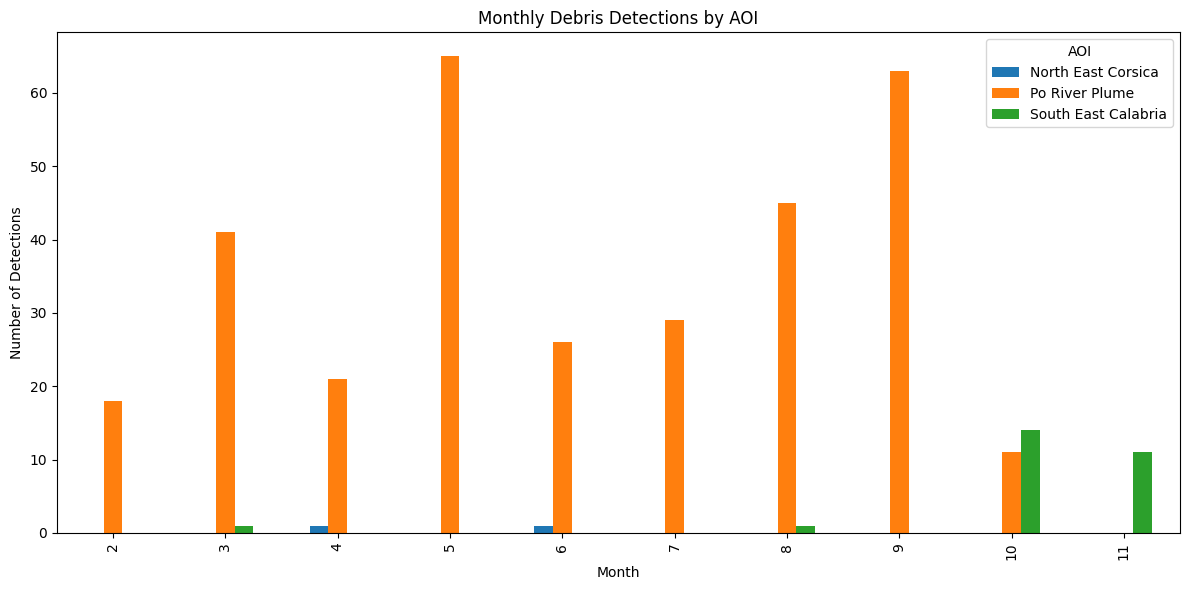

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example input dataframe structure
# Replace this with your actual DataFrame
# df should have columns: ['AOI', 'excel_month']

# Count detections per month per AOI
monthly_counts = tile_df.groupby(['AOI', 'excel_month']).size().unstack(fill_value=0)

# Plotting
monthly_counts.T.plot(kind='bar', figsize=(12, 6))
plt.title("Monthly Debris Detections by AOI")
plt.xlabel("Month")
plt.ylabel("Number of Detections")
plt.legend(title="AOI")
plt.tight_layout()


In [ ]:
#url: https://cds.climate.copernicus.eu/api
#key: 0b949b34-c27f-4c94-b32d-1953c40c08dc


In [ ]:
!pip install "cdsapi>=0.7.4"

In [ ]:
!touch .cdsapirc

In [ ]:
with open('.cdsapirc', 'w') as f:
    f.write('url: https://cds.climate.copernicus.eu/api\n key: 0b949b34-c27f-4c94-b32d-1953c40c08dc')

In [ ]:
import cdsapi
import os
os.environ['CDSAPI_RC'] = '.cdsapirc'

c = cdsapi.Client()

import cdsapi

dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "mean_wave_direction",
        "total_precipitation"
    ],
    "year": [
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021"
    ],
    "month": [
        "02", "03", "04",
        "05", "06", "07",
        "08", "09", "10",
        "11"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [46, 12, 44, 13.5]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()



2025-04-16 07:04:27,355 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-16 07:04:27,357 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-16 07:04:27,906 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-16 07:04:27,908 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter nam

ee5d5b7d6c6fc3c9ea3f88d09961c91d.zip:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

'ee5d5b7d6c6fc3c9ea3f88d09961c91d.zip'

In [ ]:
!unzip /content/ee5d5b7d6c6fc3c9ea3f88d09961c91d.zip -d /content/csde/

Archive:  /content/ee5d5b7d6c6fc3c9ea3f88d09961c91d.zip
  inflating: /content/csde/data_stream-oper_stepType-instant.nc  
  inflating: /content/csde/data_stream-oper_stepType-accum.nc  
  inflating: /content/csde/data_stream-wave_stepType-instant.nc  


In [ ]:
import os

extracted_dir = "/content/csde"
files = [f for f in os.listdir(extracted_dir) if f.endswith(".nc")]
print(files)


['data_stream-oper_stepType-accum.nc', 'data_stream-wave_stepType-instant.nc', 'data_stream-oper_stepType-instant.nc']


In [ ]:
import xarray as xr
import os

data_dir = "/content/csde"
files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".nc")])

# Open all datasets and combine along time
ds = xr.open_mfdataset(files, combine='by_coords')

# Show all variables
print(ds)


<xarray.Dataset> Size: 2MB
Dimensions:     (valid_time: 2123, latitude: 9, longitude: 7)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2015-02-01 ... 2021-11-30
  * latitude    (latitude) float64 72B 44.0 44.25 44.5 44.75 ... 45.5 45.75 46.0
  * longitude   (longitude) float64 56B 12.0 12.25 12.5 12.75 13.0 13.25 13.5
    number      int64 8B 0
    expver      (valid_time) <U4 34kB dask.array<chunksize=(2123,), meta=np.ndarray>
Data variables:
    tp          (valid_time, latitude, longitude) float32 535kB dask.array<chunksize=(2123, 9, 7), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 535kB dask.array<chunksize=(2123, 9, 7), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 535kB dask.array<chunksize=(2123, 9, 7), meta=np.ndarray>
    mwd         (valid_time, latitude, longitude) float32 535kB dask.array<chunksize=(2123, 5, 4), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription

In [ ]:
print(ds.dims)
print(ds.coords)


FrozenMappingWarningOnValuesAccess({'valid_time': 2123, 'latitude': 9, 'longitude': 7})
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2015-02-01 ... 2021-11-30
  * latitude    (latitude) float64 72B 44.0 44.25 44.5 44.75 ... 45.5 45.75 46.0
  * longitude   (longitude) float64 56B 12.0 12.25 12.5 12.75 13.0 13.25 13.5
    number      int64 8B 0
    expver      (valid_time) <U4 34kB dask.array<chunksize=(2123,), meta=np.ndarray>


In [ ]:
# Wind speed from u10 and v10
wind_speed = (ds['u10']**2 + ds['v10']**2)**0.5
# ERA5 tp is in meters of water; convert to mm
precip_mm = ds['tp'] * 1000



In [ ]:
monthly_wind = wind_speed.resample(valid_time='1M').mean(dim='valid_time')
monthly_precip = precip_mm.resample(valid_time='1M').sum(dim='valid_time')

# Then average over space
monthly_wind_avg = monthly_wind.mean(dim=['latitude', 'longitude'])
monthly_precip_avg = monthly_precip.mean(dim=['latitude', 'longitude'])


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [ ]:
import pandas as pd

# Combine into a DataFrame
df_po = xr.Dataset({
    'monthly_wind_mps': monthly_wind_avg,
    'monthly_precip_mm': monthly_precip_avg
}).to_dataframe().reset_index()

# Extract year and month
df_po['year'] = df_po['valid_time'].dt.year
df_po['month'] = df_po['valid_time'].dt.month

# Add AOI label
df_po['AOI'] = 'Po River Plume'


In [ ]:
df_po.head()

,valid_time,number,monthly_wind_mps,monthly_precip_mm,year,month,AOI
0,2015-02-28,0,4.335949,4.622301,2015,2,Po River Plume
1,2015-03-31,0,4.038486,3.353482,2015,3,Po River Plume
2,2015-04-30,0,3.261834,1.689676,2015,4,Po River Plume
3,2015-05-31,0,3.260656,5.000538,2015,5,Po River Plume
4,2015-06-30,0,2.797418,3.185590,2015,6,Po River Plume


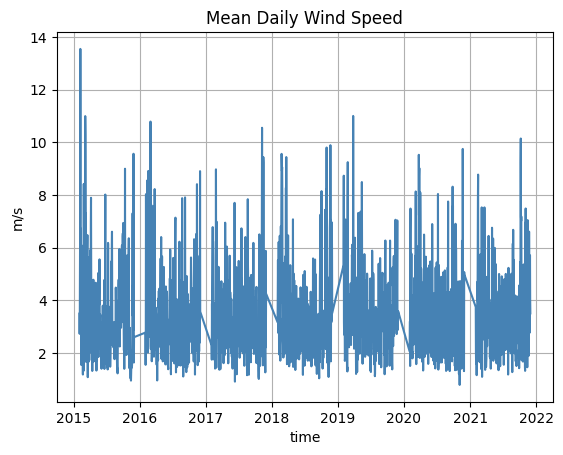

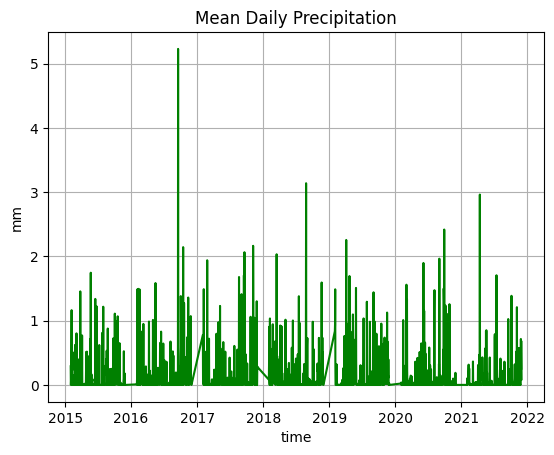

In [ ]:
import matplotlib.pyplot as plt

# Average across spatial dimensions
wind_avg = wind_speed.mean(dim=['latitude', 'longitude'])
rain_avg = precip_mm.mean(dim=['latitude', 'longitude'])

# Plot wind speed
wind_avg.plot(label="Wind Speed (m/s)", color='steelblue')
plt.title("Mean Daily Wind Speed")
plt.ylabel("m/s")
plt.grid(True)
plt.show()

# Plot precipitation
rain_avg.plot(label="Precipitation (mm)", color='green')
plt.title("Mean Daily Precipitation")
plt.ylabel("mm")
plt.grid(True)
plt.show()
